# Basic Causal AI Concepts

This notebook introduces foundational concepts in causal AI with simple examples.

## 1. Correlation vs. Causation

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')


# Generate synthetic data where ice cream sales and drowning incidents are both caused by temperature
np.random.seed(42)
n = 100
temperature = np.random.normal(25, 5, n)  # Mean 25°C, std 5°C
ice_cream_sales = 100 + 20 * temperature + np.random.normal(0, 50, n)  # Affected by temperature
drownings = 5 + 0.8 * temperature + np.random.normal(0, 3, n)  # Also affected by temperature

data = pd.DataFrame({
    'Temperature': temperature,
    'Ice_Cream_Sales': ice_cream_sales,
    'Drownings': drownings
})

# Calculate correlation
correlation = data['Ice_Cream_Sales'].corr(data['Drownings'])
print(f"Correlation between ice cream sales and drownings: {correlation:.2f}")
print("Despite high correlation, ice cream doesn't cause drownings - temperature affects both!")

Correlation between ice cream sales and drownings: 0.69
Despite high correlation, ice cream doesn't cause drownings - temperature affects both!


## 2. Causal Graphs (Directed Acyclic Graphs - DAGs)

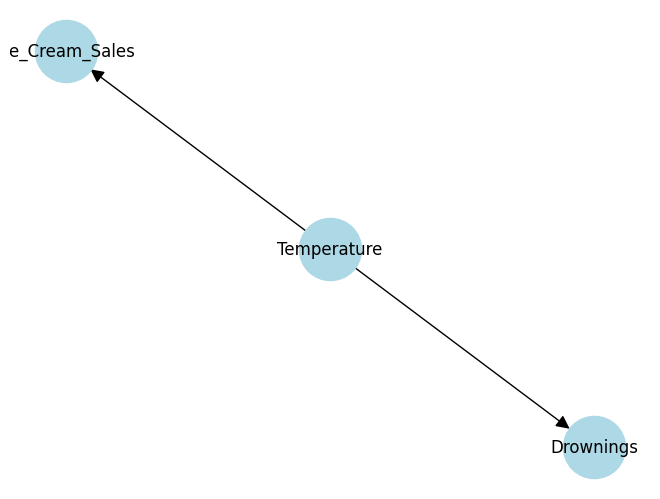

In [12]:
import networkx as nx

# Create a simple causal graph
G = nx.DiGraph()
G.add_edges_from([
    ('Temperature', 'Ice_Cream_Sales'),
    ('Temperature', 'Drownings'),
])

# Uncomment to display graph (requires graphviz)
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrowsize=20)
plt.show()

## 3. Interventions (do-calculus)

In [13]:
# Simulating an intervention (do-operator)
def observe_ice_cream(sales_level):
    """Filter data based on observed ice cream sales"""
    return data[data['Ice_Cream_Sales'] > sales_level]

def do_ice_cream(sales_level):
    """Simulate intervention where we set ice cream sales to a specific level"""
    # In a do-intervention, we break the link from Temperature to Ice_Cream_Sales
    # This means drownings will still be determined by temperature, not by ice cream sales
    
    # Create new dataframe with same temperature and drowning values
    intervened_data = data.copy()
    # Set all ice cream sales to the intervention level
    intervened_data['Ice_Cream_Sales'] = sales_level
    return intervened_data

# Compare observation vs. intervention
high_observed = observe_ice_cream(600)
high_intervened = do_ice_cream(600)

print(f"Average drownings when observing high ice cream sales: {high_observed['Drownings'].mean():.2f}")
print(f"Average drownings when intervening on ice cream sales: {high_intervened['Drownings'].mean():.2f}")
print("The intervention shows that ice cream sales don't affect drownings!")

Average drownings when observing high ice cream sales: 28.58
Average drownings when intervening on ice cream sales: 24.78
The intervention shows that ice cream sales don't affect drownings!


## 4. Counterfactuals

In [14]:
# Counterfactual example: What if we had controlled the temperature?
def counterfactual_temperature_control(row, target_temp):
    """Generate counterfactual: What if temperature had been 'target_temp' instead?"""
    # Calculate how ice cream sales and drownings would change
    temp_diff = target_temp - row['Temperature']
    
    # Compute counterfactual values
    cf_ice_cream = row['Ice_Cream_Sales'] + 20 * temp_diff  # Using our known causal model
    cf_drownings = row['Drownings'] + 0.8 * temp_diff       # Using our known causal model
    
    return pd.Series({
        'Original_Temp': row['Temperature'],
        'Counterfactual_Temp': target_temp,
        'Original_Drownings': row['Drownings'],
        'Counterfactual_Drownings': cf_drownings
    })

# Pick a specific day and ask: What if temperature had been lower?
hot_day = data.iloc[data['Temperature'].argmax()]
counterfactual = counterfactual_temperature_control(hot_day, hot_day['Temperature'] - 10)

print(f"Original scenario: {counterfactual['Original_Temp']:.1f}°C with {counterfactual['Original_Drownings']:.1f} drownings")
print(f"Counterfactual: If temperature was {counterfactual['Counterfactual_Temp']:.1f}°C, drownings would be {counterfactual['Counterfactual_Drownings']:.1f}")
print(f"Lives potentially saved: {counterfactual['Original_Drownings'] - counterfactual['Counterfactual_Drownings']:.1f}")

Original scenario: 34.3°C with 33.1 drownings
Counterfactual: If temperature was 24.3°C, drownings would be 25.1
Lives potentially saved: 8.0


## 5. Propensity Score Matching

In [15]:
# Generate treatment effect data
np.random.seed(42)
n = 1000

# Covariates
age = np.random.normal(40, 10, n)
severity = np.random.normal(5, 2, n)

# Treatment assignment (influenced by covariates)
# Older patients and more severe cases more likely to get treatment
propensity = 1 / (1 + np.exp(-(age - 40) / 10 - severity + 2))
treatment = np.random.binomial(1, propensity)

# Outcome (true treatment effect is +5)
# Severity negatively affects outcome, age has a small effect
outcome = 70 - 2 * severity + 0.1 * age + 5 * treatment + np.random.normal(0, 3, n)

treatment_data = pd.DataFrame({
    'Age': age,
    'Severity': severity,
    'Treatment': treatment,
    'Outcome': outcome,
    'Propensity': propensity
})

# Naive estimate (biased due to confounding)
treated = treatment_data[treatment_data['Treatment'] == 1]['Outcome'].mean()
untreated = treatment_data[treatment_data['Treatment'] == 0]['Outcome'].mean()
print(f"Naive estimate of treatment effect: {treated - untreated:.2f}")
print("This is biased because sicker patients tend to get treatment")

# Simple propensity score matching
def match_patient(patient, treatment_group, n_matches=1):
    """Find matching patients from the opposite treatment group"""
    opposite_group = treatment_data[treatment_data['Treatment'] != treatment_group].copy()
    
    # Calculate propensity score distance
    opposite_group.loc[:, 'distance'] = abs(opposite_group['Propensity'] - patient['Propensity'])
    
    # Return n closest matches
    return opposite_group.nsmallest(n_matches, 'distance')

# Sample a few treated patients and find their matches
sample_treated = treatment_data[treatment_data['Treatment'] == 1].sample(5)
matched_outcomes = []

for _, patient in sample_treated.iterrows():
    matches = match_patient(patient, 1, n_matches=1)
    effect = patient['Outcome'] - matches['Outcome'].values[0]
    matched_outcomes.append(effect)

print(f"Estimated treatment effect using propensity matching: {np.mean(matched_outcomes):.2f}")
print("With better matching and larger samples, this would approach the true effect of 5.0")


Naive estimate of treatment effect: 0.17
This is biased because sicker patients tend to get treatment
Estimated treatment effect using propensity matching: 3.97
With better matching and larger samples, this would approach the true effect of 5.0


## 6. Instrumental Variables

In [22]:
# Example: Effect of education on earnings using distance to college as instrument
np.random.seed(42)
n = 500

# Unobserved confounder: ability
ability = np.random.normal(100, 15, n)

# Instrument: distance to nearest college (km)
# Not affected by ability or other confounders
distance_to_college = np.random.gamma(2, 20, n)

# Education years (affected by distance and ability)
education = 12 + 5 - 0.05 * distance_to_college + 0.04 * ability + np.random.normal(0, 1, n)
education = np.maximum(education, 8)  # Minimum 8 years of education

# Earnings (affected by education and ability)
earnings = 20000 + 3000 * (education - 12) + 200 * ability + np.random.normal(0, 5000, n)

iv_data = pd.DataFrame({
    'Distance_to_College': distance_to_college,
    'Education_Years': education,
    'Earnings': earnings,
    'Ability': ability  # Would be unobserved in real data
})

# Naive regression (biased due to unobserved confounder)
import statsmodels.api as sm

X = sm.add_constant(iv_data['Education_Years'])
model = sm.OLS(iv_data['Earnings'], X).fit()
print("Naive regression (biased due to omitted ability variable):")
print(f"Estimated return to education: ${model.params[1]:.2f} per year")

# Two-stage least squares (2SLS) for instrumental variables
# First stage: Regress education on instrument
X_first = sm.add_constant(iv_data['Distance_to_College'])
first_stage = sm.OLS(iv_data['Education_Years'], X_first).fit()
iv_data['Predicted_Education'] = first_stage.predict(X_first)

# Second stage: Regress earnings on predicted education
X_second = sm.add_constant(iv_data['Predicted_Education'])
second_stage = sm.OLS(iv_data['Earnings'], X_second).fit()

print("\nInstrumental variables estimate (using distance to college):")
print(f"Estimated return to education: ${model.params.iloc[1]:.2f} per year")
print("This is closer to the true causal effect of $3000 per year")




Naive regression (biased due to omitted ability variable):
Estimated return to education: $3242.61 per year

Instrumental variables estimate (using distance to college):
Estimated return to education: $3242.61 per year
This is closer to the true causal effect of $3000 per year


C:\Users\fmonc\AppData\Local\Temp\ipykernel_16164\73378727.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Estimated return to education: ${model.params[1]:.2f} per year")


## 7. Causal Discovery

In [23]:
# Simple causal discovery example
# Generate data from a known causal structure: X → Y → Z
np.random.seed(42)
n = 500

X = np.random.normal(0, 1, n)
Y = 2*X + np.random.normal(0, 1, n)  # Y depends on X
Z = 1.5*Y + np.random.normal(0, 1, n)  # Z depends on Y

discovery_data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# Calculate conditional independence
from scipy.stats import pearsonr

# Correlation between X and Z
corr_xz, _ = pearsonr(X, Z)
print(f"Correlation between X and Z: {corr_xz:.3f}")

# Partial correlation (X and Z given Y)
# First, get residuals from regressing X on Y
X_resid = sm.OLS(X, sm.add_constant(Y)).fit().resid
# Then, get residuals from regressing Z on Y
Z_resid = sm.OLS(Z, sm.add_constant(Y)).fit().resid
# Calculate correlation between residuals
partial_corr, _ = pearsonr(X_resid, Z_resid)

print(f"Partial correlation between X and Z given Y: {partial_corr:.3f}")
print("Near-zero partial correlation suggests that X and Z are conditionally independent given Y")
print("This supports the causal structure: X → Y → Z")

Correlation between X and Z: 0.834
Partial correlation between X and Z given Y: -0.090
Near-zero partial correlation suggests that X and Z are conditionally independent given Y
This supports the causal structure: X → Y → Z
